In [1]:
import gym
import numpy as np
import torch
import wandb

import argparse
import pickle
import random
import sys

sys.path.append('/root/projects/can-wikipedia-help-offline-rl/code')

from decision_transformer.evaluation.evaluate_episodes import (
    evaluate_episode,
    evaluate_episode_rtg,
)
from decision_transformer.models.decision_transformer import DecisionTransformer
from decision_transformer.models.mlp_bc import MLPBCModel
from decision_transformer.training.act_trainer import ActTrainer
from decision_transformer.training.seq_trainer import SequenceTrainer

from utils import get_optimizer
import os

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.patches as mpatches

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'decision_transformer'

In [ ]:
def discount_cumsum(x, gamma):
    discount_cumsum = np.zeros_like(x)
    discount_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
    return discount_cumsum

def prepare_data(variant):
    env_name, dataset = variant["env"], variant["dataset"]
    model_type = variant["model_type"]
    exp_prefix = 'gym-experiment'
    group_name = f"{exp_prefix}-{env_name}-{dataset}"
    exp_prefix = f"{group_name}-{random.randint(int(1e5), int(1e6) - 1)}"

    if env_name == "hopper":
        env = gym.make("Hopper-v3")
        max_ep_len = 1000
        env_targets = [3600, 1800]  # evaluation conditioning targets
        scale = 1000.0  # normalization for rewards/returns
    elif env_name == "halfcheetah":
        env = gym.make("HalfCheetah-v3")
        max_ep_len = 1000
        env_targets = [12000, 6000]
        scale = 1000.0
    elif env_name == "walker2d":
        env = gym.make("Walker2d-v3")
        max_ep_len = 1000
        env_targets = [5000, 2500]
        scale = 1000.0
    elif env_name == "reacher2d":
        from decision_transformer.envs.reacher_2d import Reacher2dEnv

        env = Reacher2dEnv()
        max_ep_len = 100
        env_targets = [76, 40]
        scale = 10.0
    else:
        raise NotImplementedError

    if model_type == "bc":
        env_targets = env_targets[
            :1
        ]  # since BC ignores target, no need for different evaluations

    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    # load dataset
    dataset_path = f"../data/{env_name}-{dataset}-v2.pkl"
    with open(dataset_path, "rb") as f:
        trajectories = pickle.load(f)

    # save all path information into separate lists
    mode = variant.get("mode", "normal")
    states, traj_lens, returns = [], [], []
    for path in trajectories:
        if mode == "delayed":  # delayed: all rewards moved to end of trajectory
            path["rewards"][-1] = path["rewards"].sum()
            path["rewards"][:-1] = 0.0
        states.append(path["observations"])
        traj_lens.append(len(path["observations"]))
        returns.append(path["rewards"].sum())
    traj_lens, returns = np.array(traj_lens), np.array(returns)

    # used for input normalization
    states = np.concatenate(states, axis=0)
    state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

    num_timesteps = sum(traj_lens)

    print("=" * 50)
    print(f"Starting new experiment: {env_name} {dataset}")
    print(f"{len(traj_lens)} trajectories, {num_timesteps} timesteps found")
    print(f"Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}")
    print(f"Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}")
    print("=" * 50)
    
    pct_traj = variant.get("pct_traj", 1.0)

    # only train on top pct_traj trajectories (for %BC experiment)
    num_timesteps = max(int(pct_traj * num_timesteps), 1)
    sorted_inds = np.argsort(returns)  # lowest to highest
    num_trajectories = 1
    timesteps = traj_lens[sorted_inds[-1]]
    ind = len(trajectories) - 2
    while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
        timesteps += traj_lens[sorted_inds[ind]]
        num_trajectories += 1
        ind -= 1
    sorted_inds = sorted_inds[-num_trajectories:]

    # used to reweight sampling so we sample according to timesteps instead of trajectories
    p_sample = traj_lens[sorted_inds] / sum(traj_lens[sorted_inds])
    
    return trajectories, sorted_inds, state_dim, act_dim, max_ep_len, state_mean, state_std, num_trajectories, p_sample, scale

def get_batch(
    batch_size, 
    max_len,
    trajectories,
    sorted_inds,
    state_dim,
    act_dim,
    max_ep_len,
    state_mean,
    state_std,
    num_trajectories,
    p_sample,
    scale,
    device
    ):
    batch_inds = np.random.choice(
        np.arange(num_trajectories),
        size=batch_size,
        replace=True,
        p=p_sample,  # reweights so we sample according to timesteps
    )

    s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
    for i in range(batch_size):
        traj = trajectories[int(sorted_inds[batch_inds[i]])]
        si = random.randint(0, traj["rewards"].shape[0] - 1)

        # get sequences from dataset
        s.append(traj["observations"][si : si + max_len].reshape(1, -1, state_dim))
        a.append(traj["actions"][si : si + max_len].reshape(1, -1, act_dim))
        r.append(traj["rewards"][si : si + max_len].reshape(1, -1, 1))
        if "terminals" in traj:
            d.append(traj["terminals"][si : si + max_len].reshape(1, -1))
        else:
            d.append(traj["dones"][si : si + max_len].reshape(1, -1))
        timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
        timesteps[-1][timesteps[-1] >= max_ep_len] = (
            max_ep_len - 1
        )  # padding cutoff
        rtg.append(
            discount_cumsum(traj["rewards"][si:], gamma=1.0)[
                : s[-1].shape[1] + 1
            ].reshape(1, -1, 1)
        )
        if rtg[-1].shape[1] <= s[-1].shape[1]:
            rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

        # padding and state + reward normalization
        tlen = s[-1].shape[1]
        s[-1] = np.concatenate(
            [np.zeros((1, max_len - tlen, state_dim)), s[-1]], axis=1
        )
        s[-1] = (s[-1] - state_mean) / state_std
        a[-1] = np.concatenate(
            [np.ones((1, max_len - tlen, act_dim)) * -10.0, a[-1]], axis=1
        )
        r[-1] = np.concatenate([np.zeros((1, max_len - tlen, 1)), r[-1]], axis=1)
        d[-1] = np.concatenate([np.ones((1, max_len - tlen)) * 2, d[-1]], axis=1)
        rtg[-1] = (
            np.concatenate([np.zeros((1, max_len - tlen, 1)), rtg[-1]], axis=1)
            / scale
        )
        timesteps[-1] = np.concatenate(
            [np.zeros((1, max_len - tlen)), timesteps[-1]], axis=1
        )
        mask.append(
            np.concatenate(
                [np.zeros((1, max_len - tlen)), np.ones((1, tlen))], axis=1
            )
        )

    s = torch.from_numpy(np.concatenate(s, axis=0)).to(
        dtype=torch.float32, device=device
    )
    a = torch.from_numpy(np.concatenate(a, axis=0)).to(
        dtype=torch.float32, device=device
    )
    r = torch.from_numpy(np.concatenate(r, axis=0)).to(
        dtype=torch.float32, device=device
    )
    d = torch.from_numpy(np.concatenate(d, axis=0)).to(
        dtype=torch.long, device=device
    )
    rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).to(
        dtype=torch.float32, device=device
    )
    timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).to(
        dtype=torch.long, device=device
    )
    mask = torch.from_numpy(np.concatenate(mask, axis=0)).to(device=device)

    return s, a, r, d, rtg, timesteps, mask

def compute_cka(activation_1, activation_2, reward_state_action, timestep=-1):

    if reward_state_action == 'reward':
        idx = timestep * 3
    elif reward_state_action == 'state':
        idx = timestep * 2
    elif reward_state_action == 'action':
        idx = timestep * 1
    else:
        print("Specify either 'reward', 'state', or 'action'.")

    # activationの次元（activation_1.shape[1]）とcontextの次元（activation_1.shape[2]）を同一次元に潰す
    if len(activation_1.shape) == 3:
        activation_1 = activation_1[:, :, idx]
    elif len(activation_1.shape) == 4:
        activation_1 = activation_1[:, :, idx, idx]
    if len(activation_2.shape) == 3:
        activation_2 = activation_2[:, :, idx]
    elif len(activation_2.shape) == 4:
        activation_2 = activation_2[:, :, idx, idx]

    # Center
    X = activation_1 - activation_1.mean(0, keepdim=True)
    Y = activation_2 - activation_2.mean(0, keepdim=True)

    XtX_F = torch.norm(torch.mm(X.t(), X), p='fro').item()
    YtY_F = torch.norm(torch.mm(Y.t(), Y), p='fro').item()
    YtX_F = torch.norm(torch.mm(Y.t(), X), p='fro').item()

    # eq 5 in paper
    cka = YtX_F**2 / (XtX_F*YtY_F)

    return cka

def plot_cka(cka_matrix, reward_state_action, model1, model2, env_name, dataset_name, seed, epoch1, epoch2):
    
    sns.set_style("ticks")
    sns.set_context("paper", 1.5, {"lines.linewidth": 2})

    ax = sns.heatmap(cka_matrix, vmin=0, vmax=1)
    ax.axis('equal')
    plt.ylim(0, len(cka_matrix))
    plt.xlim(0, len(cka_matrix))
    plt.xlabel(f'{model1.upper()} Layers at Epoch {epoch1}')
    plt.ylabel(f'{model2.upper()} Layers at Epoch {epoch2}')
    plt.title(f'CKA: {model1.upper()} ' + r'$\times$' + f' {model1.upper()}, ' + f'{reward_state_action.upper()}')
    plt.tight_layout()
    plt.savefig(f'figs/cka_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
    plt.show()

    plt.plot(np.diag(cka_matrix), color=(0.372, 0.537, 0.537))
    plt.scatter(np.arange(len(np.diag(cka_matrix))), np.diag(cka_matrix), color=(0.372, 0.537, 0.537))
    plt.xlabel('Layer')
    plt.ylabel('CKA')
    plt.title(f'CKA per Layer: {reward_state_action.upper()}')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
    plt.show()

In [ ]:
def run_cka(
    seed=666,
    model1='gpt2',
    model2='gpt2',
    epoch1=40,
    epoch2=40,
    env_name_list=['hopper', 'halfcheetah', 'walker2d'],
    reward_state_action='action'
    ):

    for env_name in env_name_list:
        
        torch.manual_seed(seed)

        dataset_name = 'medium'

        if model1 == 'gpt2':
            pretrained_lm1 = 'gpt2'
        elif model1 == 'clip':
            pretrained_lm1 = 'openai/clip-vit-base-patch32'
        elif model1 == 'igpt':
            pretrained_lm1 = 'openai/imagegpt-small'

        variant = {
            'embed_dim': 128,
            'n_layer': 3,
            'n_head': 1,
            'activation_function': 'relu',
            'dropout': 0.2, # 0.1
            'load_checkpoint': False if epoch1==0 else f'../checkpoints/{model1}_medium_hopper_666/model_{epoch1}.pt',
            'seed': seed,
            'outdir': f"checkpoints/{model1}_{dataset_name}_{env_name}_{seed}",
            'env': env_name,
            'dataset': dataset_name,
            'model_type': 'dt',
            'K': 20, # 2
            'pct_traj': 1.0,
            'batch_size': 100,  # 64
            'num_eval_episodes': 100,
            'max_iters': 40,
            'num_steps_per_iter': 2500,
            'pretrained_lm': pretrained_lm1,
            'gpt_kmeans': None,
            'kmeans_cache': None,
            'frozen': False,
            'extend_positions': False,
            'share_input_output_proj': True
        }

        os.makedirs(variant["outdir"], exist_ok=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        trajectories, sorted_inds, state_dim, act_dim, max_ep_len, state_mean, state_std, num_trajectories, p_sample, scale = prepare_data(variant)

        K = variant["K"]
        batch_size = variant["batch_size"]

        states, actions, rewards, dones, rtg, timesteps, attention_mask = get_batch(batch_size, 
                                                                                    K,
                                                                                    trajectories,
                                                                                    sorted_inds,
                                                                                    state_dim,
                                                                                    act_dim,
                                                                                    max_ep_len,
                                                                                    state_mean,
                                                                                    state_std,
                                                                                    num_trajectories,
                                                                                    p_sample,
                                                                                    scale,
                                                                                    device
                                                                                   )
        action_target = torch.clone(actions)

        activation_list = []

        for _ in range(2):

            model = DecisionTransformer(
                args=variant,
                state_dim=state_dim,
                act_dim=act_dim,
                max_length=K,
                max_ep_len=max_ep_len,
                hidden_size=variant["embed_dim"],
                n_layer=variant["n_layer"],
                n_head=variant["n_head"],
                n_inner=4 * variant["embed_dim"],
                activation_function=variant["activation_function"],
                n_positions=1024,
                resid_pdrop=variant["dropout"],
                attn_pdrop=0.1,
            )
            if variant["load_checkpoint"]:
                state_dict = torch.load(variant["load_checkpoint"], map_location=torch.device('cpu'))
                model.load_state_dict(state_dict)
                print(f"Loaded from {variant['load_checkpoint']}")

            model.eval()

            activation = {}
            def get_activation(name):
                def hook(model, input, output):
                    activation[name] = output.detach()
                return hook

            for block_id in range(len(model.transformer.h)):
                model.transformer.h[block_id].ln_1.register_forward_hook(get_activation(f'{block_id}.ln_1'))
                model.transformer.h[block_id].attn.c_attn.register_forward_hook(get_activation(f'{block_id}.attn.c_attn'))
                model.transformer.h[block_id].attn.c_proj.register_forward_hook(get_activation(f'{block_id}.attn.c_proj'))
                model.transformer.h[block_id].attn.attn_dropout.register_forward_hook(get_activation(f'{block_id}.attn.attn_dropout'))
                model.transformer.h[block_id].attn.resid_dropout.register_forward_hook(get_activation(f'{block_id}.attn.resid_dropout'))
                model.transformer.h[block_id].ln_2.register_forward_hook(get_activation(f'{block_id}.ln_2'))
                model.transformer.h[block_id].mlp.c_fc.register_forward_hook(get_activation(f'{block_id}.mlp.c_fc'))
                model.transformer.h[block_id].mlp.c_proj.register_forward_hook(get_activation(f'{block_id}.mlp.c_proj'))
                model.transformer.h[block_id].mlp.act.register_forward_hook(get_activation(f'{block_id}.mlp.act'))
                model.transformer.h[block_id].mlp.dropout.register_forward_hook(get_activation(f'{block_id}.mlp.dropout'))

            state_preds, action_preds, reward_preds, all_embs = model.forward(
                states,
                actions,
                rewards,
                rtg[:, :-1],
                timesteps,
                attention_mask=attention_mask,
            )

            if model2 == 'gpt2':
                pretrained_lm2 = 'gpt2'
            elif model2 == 'clip':
                pretrained_lm2 = 'openai/clip-vit-base-patch32'
            elif model2 == 'igpt':
                pretrained_lm2 = 'openai/imagegpt-small'

            activation_ordered = {}
            block_name_list = [
                'ln_1',
                'attn.c_attn',
                'attn.c_proj',
                'attn.resid_dropout',
                'ln_2',
                'mlp.c_fc',
                'mlp.c_proj',
                'mlp.act',
                'mlp.dropout'
            ]
            for block_id in range(len(model.transformer.h)):
                for block_name in block_name_list:
                    activation_ordered[f'{block_id}.{block_name}'] = activation[f'{block_id}.{block_name}']

            activation_list.append(activation_ordered)
            
            variant['load_checkpoint'] = checkpoint2 = False if epoch2==0 else f'../checkpoints/{model2}_medium_hopper_666/model_{epoch2}.pt'
            variant['outdir'] =  f"checkpoints/{model2}_{dataset_name}_{env_name}_{seed}"
            variant['pretrained_lm'] = pretrained_lm2

        num_activation = len(activation_list[0].values())
        cka_matrix = []
        for key_1, act_1 in tqdm(activation_list[0].items()):
            cka_list = []
            for key_2, act_2 in activation_list[1].items():
                cka = compute_cka(act_1, act_2, reward_state_action)
                cka_list.append(cka)
            cka_matrix.append(cka_list)
        cka_matrix = np.array(cka_matrix)
        
        del model

        return cka_matrix, activation_list
            
            # plot_cka(cka_matrix, reward_state_action, model1, model2, env_name, dataset_name, seed, epoch1, epoch2)

In [ ]:
cka_diag_list = []
activations_list = []
epochs = [0, 10, 20, 30, 40]
for epoch in epochs:
    cka_matrix, activations = run_cka(
        seed=666,
        model1='gpt2',
        model2='gpt2',
        epoch1=epoch,
        epoch2=0,
        env_name_list=['hopper'],
        reward_state_action='action'
        )
    cka_diag_list.append(np.diag(cka_matrix))
    activations_list.append(activations)
    del cka_matrix

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained


/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loading from pretrained


  0%|          | 0/108 [00:00<?, ?it/s]

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained
Loaded from ../checkpoints/gpt2_medium_hopper_666/model_10.pt
Loading from pretrained


  0%|          | 0/108 [00:00<?, ?it/s]

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained
Loaded from ../checkpoints/gpt2_medium_hopper_666/model_20.pt
Loading from pretrained


  0%|          | 0/108 [00:00<?, ?it/s]

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained
Loaded from ../checkpoints/gpt2_medium_hopper_666/model_30.pt
Loading from pretrained


  0%|          | 0/108 [00:00<?, ?it/s]

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained
Loaded from ../checkpoints/gpt2_medium_hopper_666/model_40.pt
Loading from pretrained


  0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
sns.set_style("ticks")
sns.set_context("paper", 1.5, {"lines.linewidth": 2})

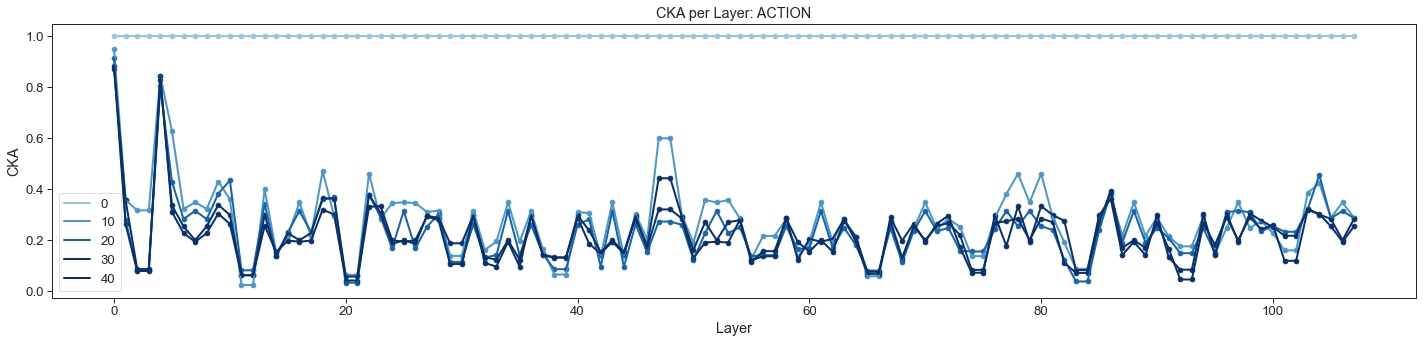

In [6]:
plt.figure(figsize=(20, 5))
reward_state_action = 'action'
for i, epoch in enumerate(epochs):
    plt.plot(cka_diag_list[i], label=f'{epoch}', color=cm.Blues((i + 2) / len(epochs)), linewidth=2)
    plt.scatter(np.arange(len(cka_diag_list[i])), cka_diag_list[i], color=cm.Blues((i + 2) / len(epochs)))
plt.xlabel('Layer')
plt.ylabel('CKA')
plt.title(f'CKA per Layer: {reward_state_action.upper()}')
# plt.ylim(0, 1)
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

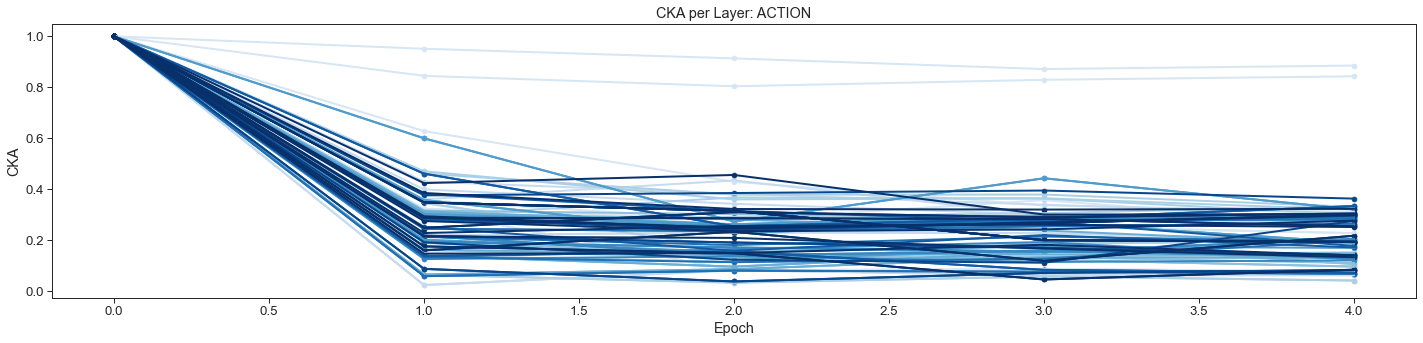

In [7]:
plt.figure(figsize=(20, 5))
reward_state_action = 'action'
colors = {str(i): cm.Blues((i + 2) / 12) for i in range(12)}
layer_names = list(activations_list[0][0].keys())
cka_diag_list_swapped = np.swapaxes(np.array(cka_diag_list), 0, 1)

for i, layer in enumerate(cka_diag_list_swapped):
    layer_name = layer_names[i]
    block_id = layer_name[:layer_name.find('.')]
    plt.plot(cka_diag_list_swapped[i], color=colors[block_id], linewidth=2)
    plt.scatter(np.arange(len(cka_diag_list_swapped[i])), cka_diag_list_swapped[i], color=colors[block_id])
plt.xlabel('Epoch')
plt.ylabel('CKA')
plt.title(f'CKA per Layer: {reward_state_action.upper()}')
# plt.ylim(0, 1)
# plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

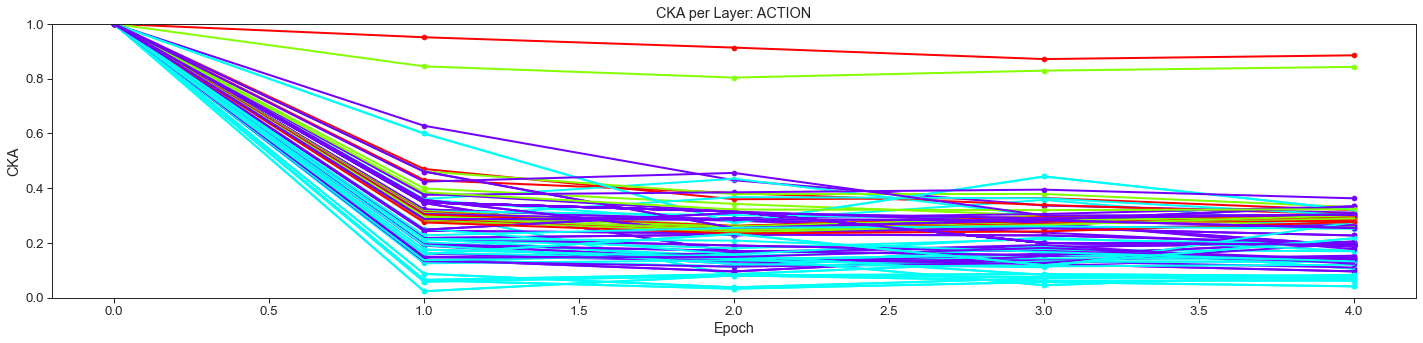

In [8]:
plt.figure(figsize=(20, 5))
reward_state_action = 'action'
colors = {i: cm.hsv((i) / 4) for i in range(4)}
layer_names = list(activations_list[0][0].keys())
cka_diag_list_swapped = np.swapaxes(np.array(cka_diag_list), 0, 1)

for i, layer in enumerate(cka_diag_list_swapped):
    layer_name = layer_names[i]
    if 'ln_1' in layer_name:
        color_id = 0
    elif 'ln_2' in layer_name:
        color_id = 1
    elif 'attn' in layer_name:
        color_id = 2
    else:
        color_id = 3
    plt.plot(cka_diag_list_swapped[i], color=colors[color_id], linewidth=2)
    plt.scatter(np.arange(len(cka_diag_list_swapped[i])), cka_diag_list_swapped[i], color=colors[color_id])
plt.xlabel('Epoch')
plt.ylabel('CKA')
plt.title(f'CKA per Layer: {reward_state_action.upper()}')
plt.ylim(0, 1)
# plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

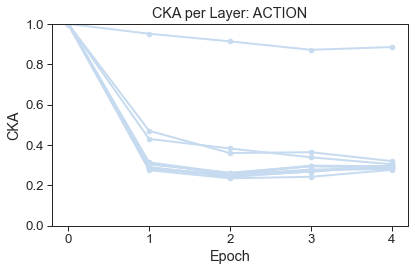

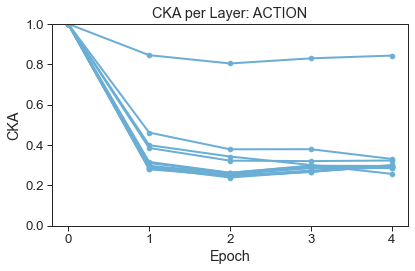

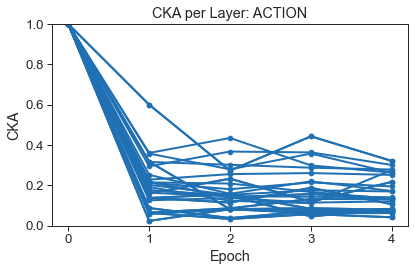

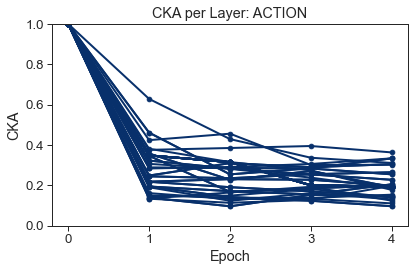

In [9]:
# plt.figure(figsize=(20, 5))
reward_state_action = 'action'
colors = {i: cm.Blues((i + 1) / 4) for i in range(4)}
layer_names = list(activations_list[0][0].keys())
cka_diag_list_swapped = np.swapaxes(np.array(cka_diag_list), 0, 1)

for i, layer in enumerate(cka_diag_list_swapped):
    layer_name = layer_names[i]
    if 'ln_1' in layer_name:
        color_id = 0
        plt.plot(cka_diag_list_swapped[i], color=colors[color_id], linewidth=2)
        plt.scatter(np.arange(len(cka_diag_list_swapped[i])), cka_diag_list_swapped[i], color=colors[color_id])
    elif 'ln_2' in layer_name:
        color_id = 1
    elif 'attn' in layer_name:
        color_id = 2
    else:
        color_id = 3
plt.xlabel('Epoch')
plt.ylabel('CKA')
plt.title(f'CKA per Layer: {reward_state_action.upper()}')
plt.ylim(0, 1)
# plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

for i, layer in enumerate(cka_diag_list_swapped):
    layer_name = layer_names[i]
    if 'ln_1' in layer_name:
        pass
    elif 'ln_2' in layer_name:
        color_id = 1
        plt.plot(cka_diag_list_swapped[i], color=colors[color_id], linewidth=2)
        plt.scatter(np.arange(len(cka_diag_list_swapped[i])), cka_diag_list_swapped[i], color=colors[color_id])
    elif 'attn' in layer_name:
        color_id = 2
    else:
        color_id = 3
plt.xlabel('Epoch')
plt.ylabel('CKA')
plt.title(f'CKA per Layer: {reward_state_action.upper()}')
plt.ylim(0, 1)
# plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

for i, layer in enumerate(cka_diag_list_swapped):
    layer_name = layer_names[i]
    if 'ln_1' in layer_name:
        pass
    elif 'ln_2' in layer_name:
        color_id = 1
    elif 'attn' in layer_name:
        color_id = 2
        plt.plot(cka_diag_list_swapped[i], color=colors[color_id], linewidth=2)
        plt.scatter(np.arange(len(cka_diag_list_swapped[i])), cka_diag_list_swapped[i], color=colors[color_id])
    else:
        color_id = 3
plt.xlabel('Epoch')
plt.ylabel('CKA')
plt.title(f'CKA per Layer: {reward_state_action.upper()}')
plt.ylim(0, 1)
# plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

for i, layer in enumerate(cka_diag_list_swapped):
    layer_name = layer_names[i]
    if 'ln_1' in layer_name:
        pass
    elif 'ln_2' in layer_name:
        color_id = 1
    elif 'attn' in layer_name:
        color_id = 2
    else:
        color_id = 3
        plt.plot(cka_diag_list_swapped[i], color=colors[color_id], linewidth=2)
        plt.scatter(np.arange(len(cka_diag_list_swapped[i])), cka_diag_list_swapped[i], color=colors[color_id])
plt.xlabel('Epoch')
plt.ylabel('CKA')
plt.title(f'CKA per Layer: {reward_state_action.upper()}')
plt.ylim(0, 1)
# plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

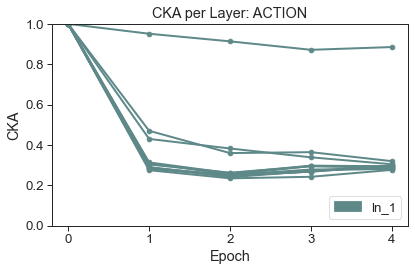

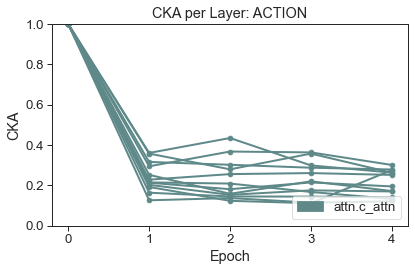

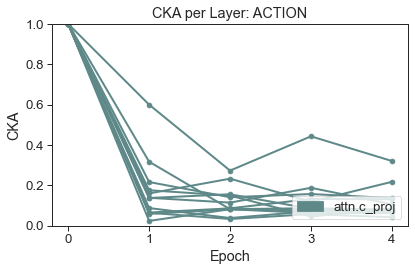

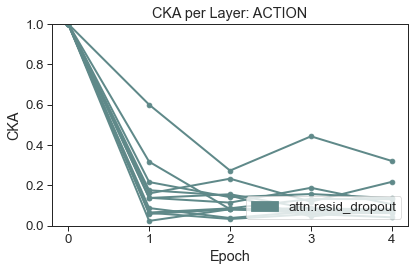

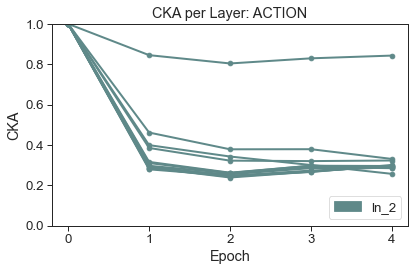

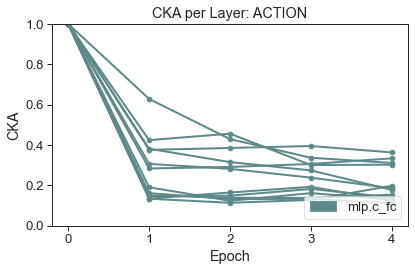

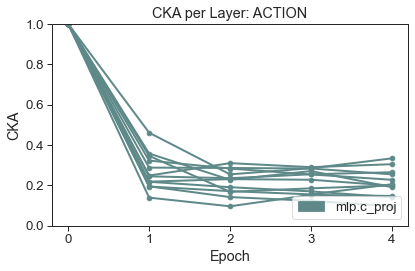

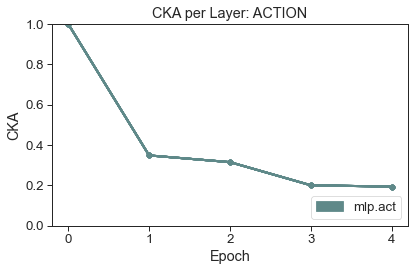

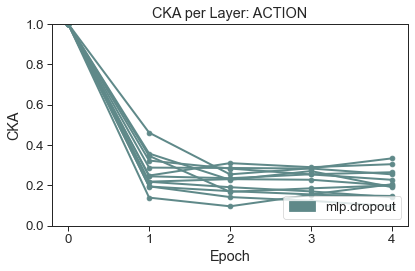

In [10]:
# plt.figure(figsize=(20, 5))

block_name_list = [
    'ln_1',
    'attn.c_attn',
    'attn.c_proj',
    'attn.resid_dropout',
    'ln_2',
    'mlp.c_fc',
    'mlp.c_proj',
    'mlp.act',
    'mlp.dropout'
]
    
reward_state_action = 'action'
colors = {i: cm.hsv((i) / 4) for i in range(4)}
layer_names = list(activations_list[0][0].keys())
cka_diag_list_swapped = np.swapaxes(np.array(cka_diag_list), 0, 1)

for block_name in block_name_list:

    for i, layer in enumerate(cka_diag_list_swapped):
        layer_name = layer_names[i]
        if block_name in layer_name:
            plt.plot(cka_diag_list_swapped[i], color=(0.372, 0.537, 0.537), linewidth=2)
            plt.scatter(np.arange(len(cka_diag_list_swapped[i])), cka_diag_list_swapped[i], color=(0.372, 0.537, 0.537))
    plt.xlabel('Epoch')
    plt.ylabel('CKA')
    plt.title(f'CKA per Layer: {reward_state_action.upper()}')
    plt.ylim(0, 1)
    patch = mpatches.Patch(color=(0.372, 0.537, 0.537), label=f'{block_name}')
    plt.legend(handles=[patch], loc='lower right')
    plt.tight_layout()
    # plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
    plt.show()

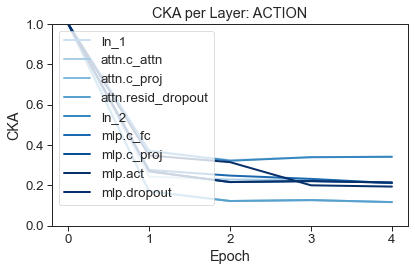

In [11]:
# plt.figure(figsize=(20, 5))

block_name_list = [
    'ln_1',
    'attn.c_attn',
    'attn.c_proj',
    'attn.resid_dropout',
    'ln_2',
    'mlp.c_fc',
    'mlp.c_proj',
    'mlp.act',
    'mlp.dropout'
]
    
reward_state_action = 'action'
colors = {i: cm.hsv((i) / len(block_name_list)) for i in range(len(block_name_list))}
layer_names = list(activations_list[0][0].keys())
cka_diag_list_swapped = np.swapaxes(np.array(cka_diag_list), 0, 1)

cka_diag_per_block = {block_name: [] for block_name in block_name_list}

for block_name in block_name_list:

    for i, layer in enumerate(cka_diag_list_swapped):
        layer_name = layer_names[i]
        if block_name in layer_name:
            cka_diag_per_block[block_name].append(layer)

for i, block_name in enumerate(block_name_list):
    mean_list = np.array(cka_diag_per_block[block_name]).mean(axis=0)
    std_list = np.array(cka_diag_per_block[block_name]).std(axis=0)
    plt.plot(mean_list, color=cm.Blues((i + 2) / len(block_name_list)), linewidth=2, label=block_name)
    # plt.fill_between(np.arange(len(mean_list)), mean_list - std_list, mean_list + std_list, color=(0.372, 0.537, 0.537), alpha=0.1)
    plt.legend()

plt.xlabel('Epoch')
plt.ylabel('CKA')
plt.title(f'CKA per Layer: {reward_state_action.upper()}')
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

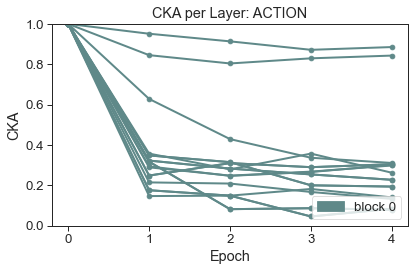

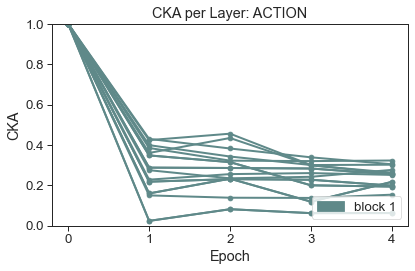

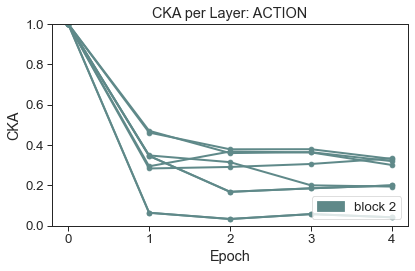

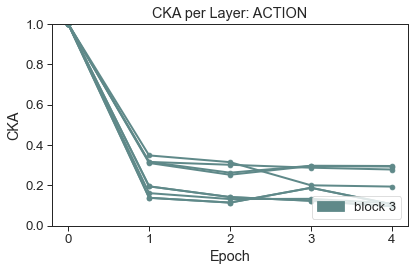

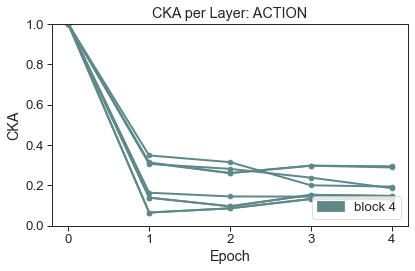

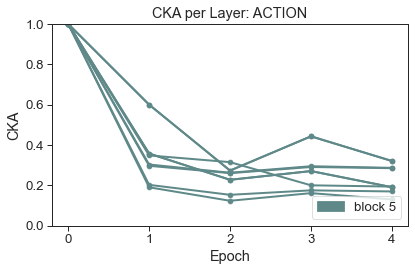

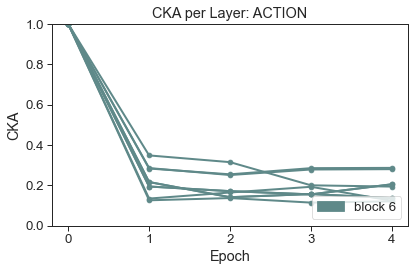

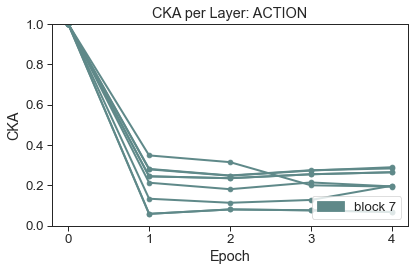

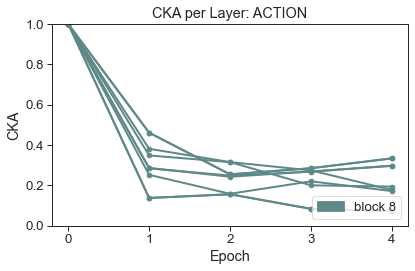

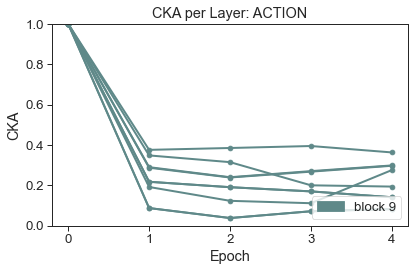

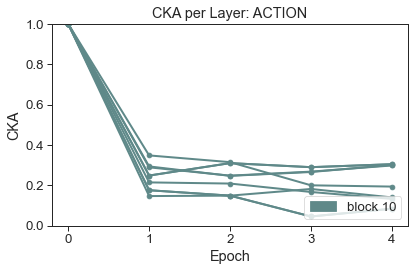

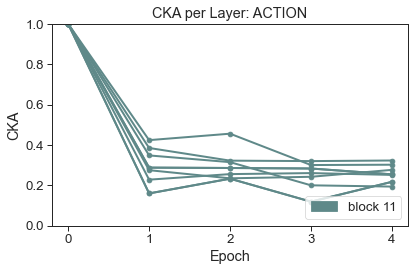

In [12]:
# plt.figure(figsize=(20, 5))

block_id_list = np.arange(12)
    
reward_state_action = 'action'
colors = {i: cm.hsv((i) / 4) for i in range(4)}
layer_names = list(activations_list[0][0].keys())
cka_diag_list_swapped = np.swapaxes(np.array(cka_diag_list), 0, 1)

for block_id in block_id_list:

    for i, layer in enumerate(cka_diag_list_swapped):
        layer_name = layer_names[i]
        if f'{block_id}.' in layer_name:
            plt.plot(cka_diag_list_swapped[i], color=(0.372, 0.537, 0.537), linewidth=2)
            plt.scatter(np.arange(len(cka_diag_list_swapped[i])), cka_diag_list_swapped[i], color=(0.372, 0.537, 0.537))
    plt.xlabel('Epoch')
    plt.ylabel('CKA')
    plt.title(f'CKA per Layer: {reward_state_action.upper()}')
    plt.ylim(0, 1)
    patch = mpatches.Patch(color=(0.372, 0.537, 0.537), label=f'block {block_id}')
    plt.legend(handles=[patch], loc='lower right')
    plt.tight_layout()
    # plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
    plt.show()

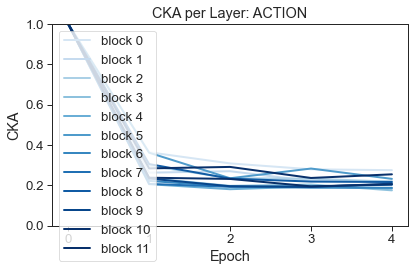

In [13]:
# plt.figure(figsize=(20, 5))

block_id_list = np.arange(12)
    
reward_state_action = 'action'
colors = {i: cm.hsv((i) / len(block_name_list)) for i in range(len(block_name_list))}
layer_names = list(activations_list[0][0].keys())
cka_diag_list_swapped = np.swapaxes(np.array(cka_diag_list), 0, 1)

cka_diag_per_block = {block_id: [] for block_id in block_id_list}

for block_id in block_id_list:

    for i, layer in enumerate(cka_diag_list_swapped):
        layer_name = layer_names[i]
        if f'{block_id}.' in layer_name:
            cka_diag_per_block[block_id].append(layer)

for i, block_id in enumerate(block_id_list):
    mean_list = np.array(cka_diag_per_block[block_id]).mean(axis=0)
    std_list = np.array(cka_diag_per_block[block_id]).std(axis=0)
    plt.plot(mean_list, color=cm.Blues((i + 2) / len(block_id_list)), linewidth=2, label=f'block {block_id}')
    # plt.fill_between(np.arange(len(mean_list)), mean_list - std_list, mean_list + std_list, color=(0.372, 0.537, 0.537), alpha=0.1)
    plt.legend()

plt.xlabel('Epoch')
plt.ylabel('CKA')
plt.title(f'CKA per Layer: {reward_state_action.upper()}')
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig(f'figs/cka_plot_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

In [11]:
list(activations_list[0][0].keys())

['0.ln_1',
 '0.attn.c_attn',
 '0.attn.c_proj',
 '0.attn.resid_dropout',
 '0.ln_2',
 '0.mlp.c_fc',
 '0.mlp.c_proj',
 '0.mlp.act',
 '0.mlp.dropout',
 '1.ln_1',
 '1.attn.c_attn',
 '1.attn.c_proj',
 '1.attn.resid_dropout',
 '1.ln_2',
 '1.mlp.c_fc',
 '1.mlp.c_proj',
 '1.mlp.act',
 '1.mlp.dropout',
 '2.ln_1',
 '2.attn.c_attn',
 '2.attn.c_proj',
 '2.attn.resid_dropout',
 '2.ln_2',
 '2.mlp.c_fc',
 '2.mlp.c_proj',
 '2.mlp.act',
 '2.mlp.dropout',
 '3.ln_1',
 '3.attn.c_attn',
 '3.attn.c_proj',
 '3.attn.resid_dropout',
 '3.ln_2',
 '3.mlp.c_fc',
 '3.mlp.c_proj',
 '3.mlp.act',
 '3.mlp.dropout',
 '4.ln_1',
 '4.attn.c_attn',
 '4.attn.c_proj',
 '4.attn.resid_dropout',
 '4.ln_2',
 '4.mlp.c_fc',
 '4.mlp.c_proj',
 '4.mlp.act',
 '4.mlp.dropout',
 '5.ln_1',
 '5.attn.c_attn',
 '5.attn.c_proj',
 '5.attn.resid_dropout',
 '5.ln_2',
 '5.mlp.c_fc',
 '5.mlp.c_proj',
 '5.mlp.act',
 '5.mlp.dropout',
 '6.ln_1',
 '6.attn.c_attn',
 '6.attn.c_proj',
 '6.attn.resid_dropout',
 '6.ln_2',
 '6.mlp.c_fc',
 '6.mlp.c_proj',
 '6

In [36]:
np.swapaxes(np.array(cka_diag_list), 0, 1).shape

(108, 5)

In [38]:
np.swapaxes(np.array(cka_diag_list), 0, 1)[0].shape

(5,)

In [7]:
cka_diag_list[0].shape

(108,)